# Installs

In [ ]:
!pip install "numpy<2.0"
!pip install torch==2.1.0+cu118 torchvision==0.16.0+cu118 torchaudio==2.1.0 --index-url https://download.pytorch.org/whl/cu118

!pip install torch_geometric


Looking in indexes: https://download.pytorch.org/whl/cu118


In [ ]:
!pip install scikit-optimize

# Imports

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import GraphSAGE, GCNConv, GATConv, GINConv, LayerNorm, BatchNorm
from torch_geometric.nn import global_mean_pool, global_max_pool, global_add_pool, global_sort_pool
from torch_geometric.data import DataLoader
from torch_geometric.nn.aggr import SumAggregation, MeanAggregation, MaxAggregation, StdAggregation

import numpy as np
import pandas as pd
import time
import psutil
import os
import pickle
from typing import Dict, List, Tuple, Any
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report
from sklearn.model_selection import StratifiedKFold
import warnings
from torch_geometric.datasets import TUDataset
from sklearn.model_selection import ParameterSampler

warnings.filterwarnings('ignore')

# Bayesian Optimization imports
try:
    from skopt import gp_minimize
    from skopt.space import Real, Integer, Categorical
    from skopt.utils import use_named_args
    from skopt.acquisition import gaussian_ei
    BAYESIAN_OPT_AVAILABLE = True
except ImportError:
    print("Warning: scikit-optimize not available. Please install with: pip install scikit-optimize")
    BAYESIAN_OPT_AVAILABLE = False

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import SAGEConv, global_mean_pool, global_max_pool, global_add_pool
from sklearn.model_selection import ParameterGrid
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import pickle

# Add to imports
from torch_geometric.datasets import ZINC, QM9
from torch_geometric.transforms import Compose

# Configurations

In [ ]:
torch.manual_seed(42)
np.random.seed(42)

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")


Using device: cuda


# Loading the dataset

1. **Nodes**: Amino acids.
2. **Edges**: Connections between amino acids that are within 6 Ångströms of each other.
3. **Labels**: Binary classification indicating whether a protein is an enzyme or not.

Clarification:
1. The 89 features are node features, not graph-level features (Structural information, Chemical properties)


In [ ]:
print("Loading DD dataset...")
dataset = TUDataset(root='/tmp/DD', name='DD')

print(f"Dataset: {dataset}")
print(f"Number of graphs: {len(dataset)}")
print(f"Number of features: {dataset.num_features}")
print(f"Number of classes: {dataset.num_classes}")

# Get first graph for exploration
data = dataset[0]
print(f"\nFirst graph:")
print(f"Number of nodes: {data.x.shape[0]}")
print(f"Number of edges: {data.edge_index.shape[1]}")
print(f"Node feature shape: {data.x.shape}")
print(f"Label: {data.y}")

Loading DD dataset...


Processing...
Done!


Dataset: DD(1178)
Number of graphs: 1178
Number of features: 89
Number of classes: 2

First graph:
Number of nodes: 327
Number of edges: 1798
Node feature shape: torch.Size([327, 89])
Label: tensor([0])


# DATA PREPROCESSING

In [ ]:
data_list = [data for data in dataset]

## splitting

In [ ]:
from sklearn.model_selection import train_test_split

labels = [data.y.item() for data in data_list]
all_indices = list(range(len(data_list)))

# First split: 60% train, 40% (val+test)
train_idx, temp_idx = train_test_split(
    all_indices,
    test_size=0.4,
    stratify=labels,
    random_state=42
)

# Second split: 20% val, 20% test from the remaining 40%
# So test_size=0.5 here means 50% of the 40% => 20% of the total
temp_labels = [labels[i] for i in temp_idx]
val_idx, test_idx = train_test_split(
    temp_idx,
    test_size=0.5,
    stratify=temp_labels,
    random_state=42
)


In [ ]:
print(f"Train set size: {len(train_idx)}")
print(f"Validation set size: {len(val_idx)}")
print(f"Test set size: {len(test_idx)}")


Train set size: 706
Validation set size: 236
Test set size: 236


In [ ]:
train_dataset = [data_list[i] for i in train_idx]
val_dataset = [data_list[i] for i in val_idx]
test_dataset = [data_list[i] for i in test_idx]

# data loaders

In [ ]:
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

print(f"\nBatch size: {batch_size}")
print(f"Number of training batches: {len(train_loader)}")
print(f"Number of validation batches: {len(val_loader)}")
print(f"Number of test batches: {len(test_loader)}")


Batch size: 32
Number of training batches: 23
Number of validation batches: 8
Number of test batches: 8


# TRAINING UTILITIES

In [ ]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

def get_memory_usage():
    process = psutil.Process(os.getpid())
    memory_mb = process.memory_info().rss / 1024 / 1024
    if torch.cuda.is_available():
        gpu_memory_mb = torch.cuda.memory_allocated() / 1024 / 1024
        return memory_mb, gpu_memory_mb
    return memory_mb, 0

def measure_inference_time(model, loader, device, num_samples=100):
    model.eval()
    times = []
    with torch.no_grad():
        for i, batch in enumerate(loader):
            if i * batch.y.size(0) >= num_samples:
                break
            batch = batch.to(device)
            start_time = time.time()
            _ = model(batch.x, batch.edge_index, batch.batch)
            end_time = time.time()
            batch_time = (end_time - start_time) / batch.y.size(0)
            times.append(batch_time)
    return np.mean(times) * 1000  # Convert to milliseconds


# Base Transfer Learning Model

2 pretrained base layers (GCN/GAT/GIN) with small Xavier initialization (simulating pretraining)

1 task-specific layer for my protein classification

Freeze option to freeze pretrained layers or fine-tune everything



In [ ]:
class TransferModel(nn.Module):
    def __init__(self, num_features, hidden_dim, num_classes, base_model='gcn',
                 freeze_base=False, dropout=0.3, global_pool='mean'):
        super().__init__()

        # Pretrained base layers (2 layers)
        if base_model == 'gcn':
            self.base1 = GCNConv(num_features, hidden_dim)
            self.base2 = GCNConv(hidden_dim, hidden_dim)
        elif base_model == 'gat':
            self.base1 = GATConv(num_features, hidden_dim, heads=1)
            self.base2 = GATConv(hidden_dim, hidden_dim, heads=1)
        else:  # gin
            mlp1 = nn.Sequential(nn.Linear(num_features, hidden_dim), nn.ReLU(), nn.Linear(hidden_dim, hidden_dim))
            mlp2 = nn.Sequential(nn.Linear(hidden_dim, hidden_dim), nn.ReLU(), nn.Linear(hidden_dim, hidden_dim))
            self.base1 = GINConv(mlp1)
            self.base2 = GINConv(mlp2)

        # Task-specific layers
        self.task_layer = GCNConv(hidden_dim, hidden_dim)
        self.classifier = nn.Linear(hidden_dim, num_classes)
        self.dropout = nn.Dropout(dropout)

        # Initialize with pretrained weights (Xavier with small gain)
        for layer in [self.base1, self.base2]:
            for param in layer.parameters():
                if param.dim() > 1:
                    nn.init.xavier_uniform_(param, gain=0.1)

        # Freeze base if needed
        if freeze_base:
            for param in [*self.base1.parameters(), *self.base2.parameters()]:
                param.requires_grad = False

        self.global_pool = {'mean': global_mean_pool, 'max': global_max_pool, 'add': global_add_pool}[global_pool]

    def forward(self, x, edge_index, batch):
        # Pretrained base
        x = F.relu(self.base1(x, edge_index))
        x = self.dropout(x)
        x = F.relu(self.base2(x, edge_index))
        x = self.dropout(x)

        # Task-specific
        x = F.relu(self.task_layer(x, edge_index))
        x = self.global_pool(x, batch)
        return self.classifier(x)

# Evalutation of model

In [ ]:
def evaluate(model, loader, device):
    model.eval()
    correct = total = 0
    with torch.no_grad():
        for batch in loader:
            batch = batch.to(device)
            pred = model(batch.x, batch.edge_index, batch.batch).argmax(dim=1)
            correct += (pred == batch.y).sum().item()
            total += batch.y.size(0)
    return correct / total

def evaluate_detailed(model, loader, device):
    model.eval()
    all_preds, all_labels = [], []
    with torch.no_grad():
        for batch in loader:
            batch = batch.to(device)
            pred = model(batch.x, batch.edge_index, batch.batch).argmax(dim=1)
            all_preds.extend(pred.cpu().numpy())
            all_labels.extend(batch.y.cpu().numpy())

    return {
        'accuracy': accuracy_score(all_labels, all_preds),
        'f1': f1_score(all_labels, all_preds, average='binary'),
        'precision': precision_score(all_labels, all_preds, average='binary'),
        'recall': recall_score(all_labels, all_preds, average='binary'),
        'predictions': all_preds,
        'labels': all_labels
    }


# Training and evalutation function

In [ ]:
def train_evaluate(model, train_loader, val_loader, test_loader, device, epochs=100, plot_training=False):
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    criterion = nn.CrossEntropyLoss()
    best_val_acc = 0
    patience_counter = 0
    start_time = time.time()

    # For plotting and peak memory tracking
    train_losses, val_losses, train_accs, val_accs = [], [], [], []
    epoch_times = []
    peak_train_cpu = peak_train_gpu = 0
    peak_inf_cpu = peak_inf_gpu = 0

    for epoch in range(epochs):
        epoch_start = time.time()

        # Train with peak memory tracking
        model.train()
        epoch_loss = 0
        for batch in train_loader:
            batch = batch.to(device)
            optimizer.zero_grad()
            out = model(batch.x, batch.edge_index, batch.batch)
            loss = criterion(out, batch.y)
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()

        # Track peak memory during training
        cpu_mem, gpu_mem = get_memory_usage()
        peak_train_cpu = max(peak_train_cpu, cpu_mem)
        peak_train_gpu = max(peak_train_gpu, gpu_mem)

        epoch_time = time.time() - epoch_start
        epoch_times.append(epoch_time)

        # Validate every 10 epochs
        if epoch % 10 == 0:
            val_acc = evaluate(model, val_loader, device)
            train_acc = evaluate(model, train_loader, device)
            val_loss = evaluate_loss(model, val_loader, device, criterion)

            train_losses.append(epoch_loss / len(train_loader))
            val_losses.append(val_loss)
            train_accs.append(train_acc)
            val_accs.append(val_acc)

            if val_acc > best_val_acc:
                best_val_acc = val_acc
                patience_counter = 0
            else:
                patience_counter += 1

            if patience_counter >= 5:  # Early stopping
                break

    training_time = time.time() - start_time

    # Plot training curves for best model
    if plot_training:
        plt.figure(figsize=(15, 5))
        epochs_range = range(0, len(train_losses) * 10, 10)

        plt.subplot(1, 3, 1)
        plt.plot(epochs_range, train_losses, 'b-', label='Train Loss')
        plt.plot(epochs_range, val_losses, 'r-', label='Validation Loss')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.title('Train vs Validation Loss')
        plt.legend()

        plt.subplot(1, 3, 2)
        plt.plot(epochs_range, train_accs, 'b-', label='Train Accuracy')
        plt.plot(epochs_range, val_accs, 'r-', label='Validation Accuracy')
        plt.xlabel('Epoch')
        plt.ylabel('Accuracy')
        plt.title('Train vs Validation Accuracy')
        plt.legend()

        plt.subplot(1, 3, 3)
        plt.plot(epochs_range, train_losses, 'b-', label='Train Loss')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.title('Training Loss')
        plt.legend()

        plt.tight_layout()
        plt.savefig('training_curves.png', dpi=300, bbox_inches='tight')
        plt.show()

    # Peak memory during inference
    torch.cuda.empty_cache() if torch.cuda.is_available() else None
    model.eval()
    with torch.no_grad():
        for batch in test_loader:
            batch = batch.to(device)
            _ = model(batch.x, batch.edge_index, batch.batch)
            cpu_mem, gpu_mem = get_memory_usage()
            peak_inf_cpu = max(peak_inf_cpu, cpu_mem)
            peak_inf_gpu = max(peak_inf_gpu, gpu_mem)

    metrics = evaluate_detailed(model, test_loader, device)
    inference_time = measure_inference_time(model, test_loader, device)

    metrics.update({
        'training_time': training_time,
        'avg_epoch_time': np.mean(epoch_times),
        'parameters': count_parameters(model),
        'peak_train_cpu_mb': peak_train_cpu,
        'peak_train_gpu_mb': peak_train_gpu,
        'peak_inf_cpu_mb': peak_inf_cpu,
        'peak_inf_gpu_mb': peak_inf_gpu,
        'inference_time_ms': inference_time
    })

    return metrics

# Helper function for validation loss


In [ ]:
def evaluate_loss(model, loader, device, criterion):
    model.eval()
    total_loss = 0
    with torch.no_grad():
        for batch in loader:
            batch = batch.to(device)
            out = model(batch.x, batch.edge_index, batch.batch)
            loss = criterion(out, batch.y)
            total_loss += loss.item()
    return total_loss / len(loader)

# Optimize the model

In [ ]:
def run_transfer_tuning(dataset, train_loader, val_loader, test_loader, device, n_trials=30):
    model_name = "Transfer Learning"
    param_dist = {
        'hidden_dim': [64, 128, 256],
        'base_model': ['gcn', 'gat', 'gin'],
        'freeze_base': [True, False],
        'dropout': [0.1, 0.3, 0.5],
        'global_pool': ['mean', 'max', 'add'],
    }

    results = []
    best_f1 = 0
    best_params = None

    print(f"{model_name}Model Random Search ({n_trials} trials)")
    print("=" * 50)

    # Random search
    for i, params in enumerate(ParameterSampler(param_dist, n_iter=n_trials, random_state=42)):
        print(f"Trial {i+1}/{n_trials}: {params}")

        model = TransferModel(
            num_features=dataset.num_features,
            num_classes=dataset.num_classes,
            **params
        ).to(device)

        metrics = train_evaluate(model, train_loader, val_loader, test_loader, device)

        result = {**params, **metrics}
        results.append(result)

        print(f"  F1: {metrics['f1']:.4f}, Acc: {metrics['accuracy']:.4f}, "
              f"Params: {metrics['parameters']}, Time: {metrics['training_time']:.1f}s")

        if metrics['f1'] > best_f1:
            best_f1 = metrics['f1']
            best_params = params

    # Train best model with plotting
    print(f"\nTraining best model with plotting: {best_params}")
    best_model = TransferModel(
        num_features=dataset.num_features,
        num_classes=dataset.num_classes,
        **best_params
    ).to(device)

    best_metrics = train_evaluate(best_model, train_loader, val_loader, test_loader, device, plot_training=True)

    # Results analysis
    df = pd.DataFrame(results)
    df.to_csv(f'{model_name}_results.csv', index=False)  # Fixed filename
    torch.save(best_model.state_dict(), f'best_{model_name}_model.pth')  # Fixed filename

    # Print comprehensive comparison
    best_result = df.loc[df['f1'].idxmax()]
    print("\n" + "=" * 70)
    print("COMPREHENSIVE RESULTS COMPARISON")
    print("=" * 70)

    # Get available columns for top 5 display
    available_cols = ['hidden_dim', 'base_model', 'dropout', 'global_pool',
                     'accuracy', 'f1', 'precision', 'recall', 'parameters',
                     'training_time']

    # Add inference_time_ms if it exists
    if 'inference_time_ms' in df.columns:
        available_cols.append('inference_time_ms')

    # Filter to only existing columns
    display_cols = [col for col in available_cols if col in df.columns]

    # Top 5 models
    top5 = df.nlargest(5, 'f1')[display_cols]
    print("\nTOP 5 CONFIGURATIONS:")
    print(top5.round(4).to_string(index=False))

    # Global pooling comparison (was aggregation)
    print("\nPERFORMANCE BY GLOBAL POOLING:")
    pool_metrics = ['accuracy', 'f1', 'parameters', 'training_time']
    if 'inference_time_ms' in df.columns:
        pool_metrics.append('inference_time_ms')

    # Filter to existing columns
    pool_metrics = [col for col in pool_metrics if col in df.columns]

    pool_comp = df.groupby('global_pool')[pool_metrics].mean().round(4)
    print(pool_comp)

    # Print best model details with enhanced metrics
    print(f"\nBEST MODEL DETAILS:")
    print(f"Configuration: {best_params}")
    print(f"Accuracy: {best_metrics['accuracy']:.4f}")
    print(f"F1-Score: {best_metrics['f1']:.4f}")
    print(f"Precision: {best_metrics['precision']:.4f}")
    print(f"Recall: {best_metrics['recall']:.4f}")
    print(f"Trainable Parameters: {best_metrics['parameters']:,}")
    print(f"Training Time: {best_metrics['training_time']:.2f}s")

    # Print optional metrics if they exist
    if 'avg_epoch_time' in best_metrics:
        print(f"Avg Time/Epoch: {best_metrics['avg_epoch_time']:.2f}s")
    if 'inference_time_ms' in best_metrics:
        print(f"Inference Time/Sample: {best_metrics['inference_time_ms']:.2f}ms")
    if 'peak_train_cpu_mb' in best_metrics:
        print(f"Peak Memory Training - CPU: {best_metrics['peak_train_cpu_mb']:.1f} MB")
    if 'peak_train_gpu_mb' in best_metrics:
        print(f"Peak Memory Training - GPU: {best_metrics['peak_train_gpu_mb']:.1f} MB")
    if 'peak_inf_cpu_mb' in best_metrics:
        print(f"Peak Memory Inference - CPU: {best_metrics['peak_inf_cpu_mb']:.1f} MB")
    if 'peak_inf_gpu_mb' in best_metrics:
        print(f"Peak Memory Inference - GPU: {best_metrics['peak_inf_gpu_mb']:.1f} MB")

    # Plotting with additional metrics
    fig, axes = plt.subplots(2, 4, figsize=(20, 10))

    # Performance by global pooling (was aggregation)
    pool_stats = df.groupby('global_pool')[['accuracy', 'f1']].mean()
    pool_stats.plot(kind='bar', ax=axes[0,0], title='Performance by Global Pooling')

    # Parameters by global pooling
    df.groupby('global_pool')['parameters'].mean().plot(kind='bar', ax=axes[0,1],
                                                        title='Parameters by Global Pooling', color='orange')

    # Training time by hidden dimension
    df.groupby('hidden_dim')['training_time'].mean().plot(kind='line', ax=axes[0,2],
                                                          title='Training Time vs Hidden Dim', marker='o', color='red')

    # Inference time by base_model (instead of layers)
    if 'inference_time_ms' in df.columns:
        df.groupby('base_model')['inference_time_ms'].mean().plot(kind='bar', ax=axes[0,3],
                                                                  title='Inference Time by Layers', color='green')
    else:
        # Alternative plot if inference time not available
        df.groupby('base_model')['training_time'].mean().plot(kind='bar', ax=axes[0,3],
                                                              title='Training Time by Layers', color='green')

    # F1 vs Parameters scatter
    axes[1,0].scatter(df['parameters'], df['f1'])
    axes[1,0].set_xlabel('Parameters')
    axes[1,0].set_ylabel('F1 Score')
    axes[1,0].set_title('F1 vs Model Size')

    # Training time vs F1
    axes[1,1].scatter(df['training_time'], df['f1'])
    axes[1,1].set_xlabel('Training Time (s)')
    axes[1,1].set_ylabel('F1 Score')
    axes[1,1].set_title('F1 vs Training Time')

    # Memory usage by global pool (if available)
    if 'peak_train_cpu_mb' in df.columns and 'peak_train_gpu_mb' in df.columns:
        df.groupby('global_pool')[['peak_train_cpu_mb', 'peak_train_gpu_mb']].mean().plot(kind='bar',
                                                                                  ax=axes[1,2], title='Memory by Global Pool')
    elif 'memory_cpu_mb' in df.columns and 'memory_gpu_mb' in df.columns:
        df.groupby('global_pool')[['memory_cpu_mb', 'memory_gpu_mb']].mean().plot(kind='bar',
                                                                                  ax=axes[1,2], title='Memory by Global Pool')
    else:
        # Alternative plot if memory metrics not available
        df.groupby('global_pool')['f1'].mean().plot(kind='bar', ax=axes[1,2],
                                                    title='F1 by Global Pool', color='purple')

    # Performance summary heatmap (global_pool vs hidden_dim)
    pivot_data = df.pivot_table(values='f1', index='global_pool', columns='hidden_dim', aggfunc='mean')
    im = axes[1,3].imshow(pivot_data.values, cmap='viridis', aspect='auto')
    axes[1,3].set_xticks(range(len(pivot_data.columns)))
    axes[1,3].set_xticklabels(pivot_data.columns)
    axes[1,3].set_yticks(range(len(pivot_data.index)))
    axes[1,3].set_yticklabels(pivot_data.index)
    axes[1,3].set_title('F1 Heatmap (Global Pool vs Hidden)')
    plt.colorbar(im, ax=axes[1,3])

    plt.tight_layout()
    plt.savefig(f'{model_name}_analysis.png', dpi=300, bbox_inches='tight')
    plt.show()

    # Save detailed results
    with open(f'{model_name}_detailed_results.pkl', 'wb') as f:
        pickle.dump({'results': df, 'best_model_params': best_metrics}, f)

    print(f"\nSaved: {model_name}_results.csv, best_{model_name}_model.pth, {model_name}_analysis.png")
    if 'plot_training' in locals():
        print("training_curves.png")

    return df, best_model

Transfer LearningModel Random Search (30 trials)
Trial 1/30: {'hidden_dim': 256, 'global_pool': 'max', 'freeze_base': False, 'dropout': 0.5, 'base_model': 'gin'}
  F1: 0.6022, Acc: 0.6864, Params: 286722, Time: 32.1s
Trial 2/30: {'hidden_dim': 128, 'global_pool': 'mean', 'freeze_base': True, 'dropout': 0.1, 'base_model': 'gin'}
  F1: 0.0000, Acc: 0.5890, Params: 16770, Time: 11.6s
Trial 3/30: {'hidden_dim': 256, 'global_pool': 'max', 'freeze_base': True, 'dropout': 0.3, 'base_model': 'gin'}
  F1: 0.5809, Acc: 0.4619, Params: 66306, Time: 15.7s
Trial 4/30: {'hidden_dim': 128, 'global_pool': 'mean', 'freeze_base': True, 'dropout': 0.1, 'base_model': 'gat'}
  F1: 0.0000, Acc: 0.5890, Params: 16770, Time: 13.9s
Trial 5/30: {'hidden_dim': 128, 'global_pool': 'max', 'freeze_base': True, 'dropout': 0.5, 'base_model': 'gat'}
  F1: 0.0000, Acc: 0.5890, Params: 16770, Time: 14.1s
Trial 6/30: {'hidden_dim': 256, 'global_pool': 'mean', 'freeze_base': False, 'dropout': 0.3, 'base_model': 'gcn'}
  F

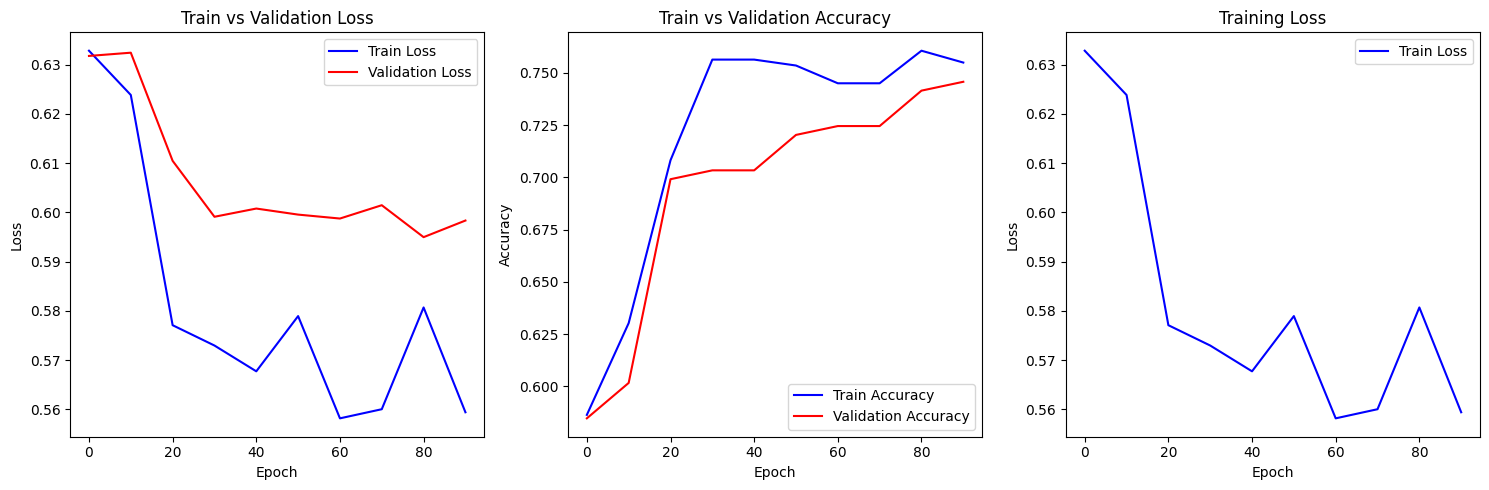


COMPREHENSIVE RESULTS COMPARISON

TOP 5 CONFIGURATIONS:
 hidden_dim base_model  dropout global_pool  accuracy     f1  precision  recall  parameters  training_time  inference_time_ms
        128        gat      0.5         add    0.7966 0.7419     0.7753  0.7113       16770        26.6904             0.1253
        256        gat      0.5         add    0.8008 0.7374     0.8049  0.6804       66306        36.2213             0.2160
         64        gcn      0.5         add    0.7924 0.7293     0.7857  0.6804       14210        25.4910             0.0874
         64        gcn      0.3         add    0.7966 0.7273     0.8101  0.6598        4290        23.2321             0.1167
        128        gin      0.3         add    0.7966 0.7209     0.8267  0.6392       16770        21.8695             0.0828

PERFORMANCE BY GLOBAL POOLING:
             accuracy      f1  parameters  training_time  inference_time_ms
global_pool                                                                
add

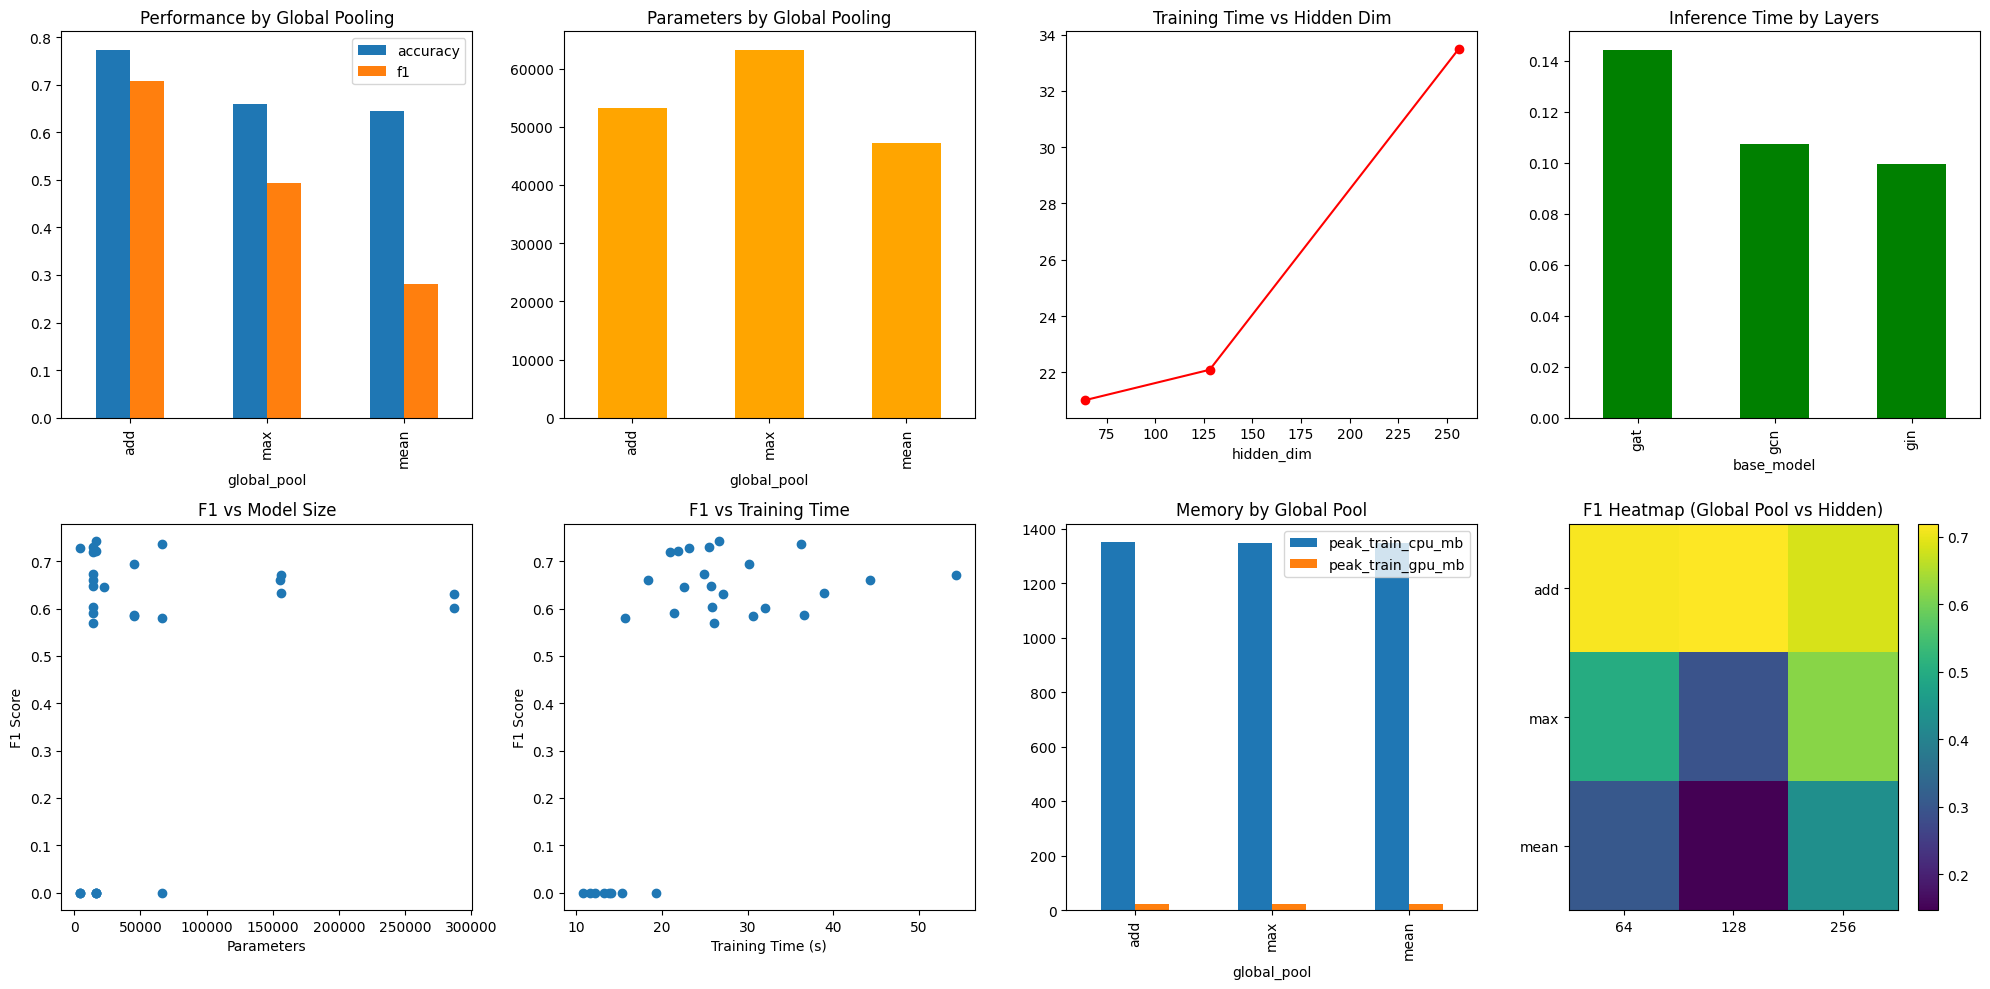


Saved: Transfer Learning_results.csv, best_Transfer Learning_model.pth, Transfer Learning_analysis.png


In [ ]:
transfer_results_df, best_transfer_model = run_transfer_tuning(dataset, train_loader, val_loader, test_loader, device, n_trials=30)